# Heater Status Notebook

## Problem Statement

Given energy consumption time series data from t1, ..., tn, predict whether the water heater is ON (1) or OFF (0) at tn for multiple locations.

### General observations of the data set

• The data set has measurements based on 5 locations.

• The time series does not exceed 7 days in duration.

### Hypothesis on how to best solve the problem

This is a binary classification problem with a time series as a predictor. Since we are working with a time series, the input features are not independent. We will have to seperate the train/validation/test sets in their own time periods. The training set will use the first half of the data set of each location, the validation set will use the next 1/4 and test set will use the final 1/4.

Let's have a look at the data set:

In [2]:
import pandas as pd

df = pd.read_csv('Data Scientist Question - Training Data Set.csv')
df.head()

,locationId,timestamp,mains,status
0,location01,2016-01-12 3:59:00,1536,0
1,location01,2016-01-12 4:00:00,2513,0
2,location01,2016-01-12 4:01:00,2582,0
3,location01,2016-01-12 4:02:00,2986,0
4,location01,2016-01-12 4:03:00,1035,0


I will be comparing the following classification algorithms: Logistic Regression, Decision Tree, Random Forest, KNN, Linear Discriminant Analysis, Naive Bayes (Gaussian NB) and SVC. I could also build a model in tensorflow, but the data set is too limited and it would likely be a waste of time since it wouldn't perform much better than the other algorithms. Normally, I would test different hyperparameter for each algorithm (or at least the top 3), but due to time-constraints, I will simply choose the default parameters to compare the algorithms. After I have chosen an algorithm, I will optimize it.

Since there are many more negative (OFF) cases than there are positive (ON) cases, the F1-Score will be a much better metric than the accuracy score. We will still calculate the accuracy score in order to get an idea of how many predictions we got right. However, when deciding on which model we choose, we will compare the F1-Scores.

Accuracy scores in location order:  [94.51428571428572, 92.057142857142864, 80.450000000000003, 82.933333333333337, 92.25]
F1-Scores in location order:  [0.64705882352941169, 0.29441624365482233, 0.48074369189907035, 0.56164383561643838, 0.70809792843691144]
LR Accuracy score: 89.269841
LR F1-Score: 0.555029
confusion matrix
 [[6503  406]
 [ 439  527]]
(row=expected, col=predicted) 



/Users/jacquesthibodeau/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Accuracy scores in location order:  [94.799999999999997, 92.114285714285714, 80.800000000000011, 83.200000000000003, 90.549999999999997]
F1-Scores in location order:  [0.67148014440433224, 0.49264705882352944, 0.49869451697127931, 0.58823529411764708, 0.68656716417910446]
LDA Accuracy score: 89.015873
LDA F1-Score: 0.582327
confusion matrix
 [[6407  502]
 [ 363  603]]
(row=expected, col=predicted) 

Accuracy scores in location order:  [94.857142857142861, 75.771428571428572, 78.849999999999994, 73.333333333333329, 83.549999999999997]
F1-Scores in location order:  [0.70000000000000007, 0.256140350877193, 0.52631578947368418, 0.41860465116279072, 0.48351648351648358]
KNN Accuracy score: 82.653968
KNN F1-Score: 0.468896
confusion matrix
 [[5906 1003]
 [ 363  603]]
(row=expected, col=predicted) 

Accuracy scores in location order:  [94.171428571428578, 83.142857142857139, 78.25, 71.733333333333334, 82.099999999999994]
F1-Scores in location order:  [0.65306122448979598, 0.28915662650602408,

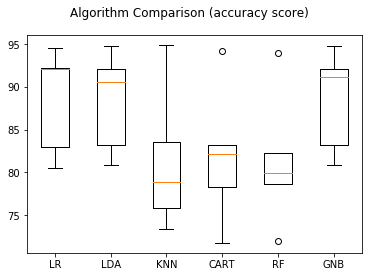

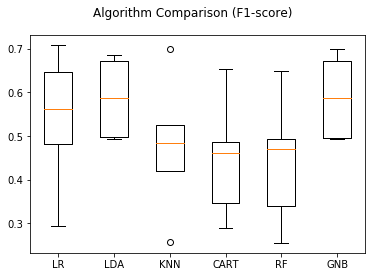

In [55]:
# Compare algorithms
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn import preprocessing
# load dataset
df = pd.read_csv('Data Scientist Question - Training Data Set.csv')

# LabelEncoder helps us convert each location ID to an integer, 
# this makes it easier for classification
le = preprocessing.LabelEncoder()
le.fit(df['locationId'])
df['locationId'] = le.transform(df['locationId'])

# preparing arrays for loop
X_train = []
X_test = []
y_train = []
y_test = []
y_test_i = []
X_validation = []
y_validation = []
y_validation_i = []
i=0
# this loop separates each location into their own data sets and
# separates each of those data sets into train/validation/test sets
    for location in df['locationId'].unique():
    # training set contains the first 50% of data, the validation set will 
    # use the next 1/4 and test set will use the final 1/4.
    train_size = int(len(df[df['locationId'] == location]['mains']) * 0.5)
    validation_size = int(len(df[df['locationId'] == location]['mains']) * 0.75)
    
    # separating features and the target variable for a specific location ID
    X = df[df['locationId'] == location]
    X = X.ix[:,[0,2]].values
    y = (df[df['locationId'] == location]['status']).values
    
    X_train.append({location: X[0:train_size]})
    y_train.append({location: y[0:train_size]})
    
    X_validation.append(X[train_size:validation_size])
    y_validation.append(y[train_size:validation_size])
    y_validation_i.append({location: y[train_size:validation_size]})
    
    X_test.append(X[validation_size:])
    y_test.append(y[validation_size:])
    y_test_i.append({location: y[validation_size:]})
    
    i=i+1

# for when we'll want to calculate the scores on the whole validation/test sets
y_validation = [yi for sublist in y_validation for yi in sublist]
y_test = [yi for sublist in y_test for yi in sublist]

# prepare configuration for validation test harness
seed = 3

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('SVM', SVC()))

all_scores_f1 = []
all_scores_accuracy = []
names = []
for name, model in models:
    # evaluate each model in turn
    scores_f1 = []
    scores_accuracy = []
    predictions = []
    i = 0
    # let's fit each model to each location ID
    for location_i in df['locationId'].unique():
        # let's seperate our input features (X) from our target variables (y)
        X_train_location_i = X_train[i][location_i]
        y_train_location_i = y_train[i][location_i]
        HeaterStatus = model
        model_instance = HeaterStatus
        model_instance.fit(X_train_location_i, y_train_location_i)

        # let's predict the status of the heater at each timestep
        prediction = []
        for location, wattage in X_validation[i][:]:
            prediction.append(model_instance.predict(np.array([[location, wattage]])))

        predictions.append(prediction)
        
        # we will now calculate the accuracy score and the F1-score.
        # the F1-score is much more important because the accuracy score
        # suffers from the Accuracy Paradox.
        scores_accuracy.append(accuracy_score(y_validation_i[i][location_i], prediction)*100)
        scores_f1.append(f1_score(y_validation_i[i][location_i], prediction))
        i = i+1
    
    # let's collect all the scores and print them out to compare each algorithm
    print("Accuracy scores in location order: ", scores_accuracy)
    print("F1-Scores in location order: ", scores_f1)
    all_scores_f1.append(scores_f1)
    all_scores_accuracy.append(scores_accuracy)
    names.append(name)
    predictions = [yi for sublist in predictions for yi in sublist]
    accuracy_msg = "%s Accuracy score: %f" % (name, accuracy_score(y_validation, predictions)*100)
    print(accuracy_msg)
    f1_msg = "%s F1-Score: %f" % (name, f1_score(y_validation, predictions))
    print(f1_msg)
    print('confusion matrix\n', confusion_matrix(y_validation, predictions))
    print('(row=expected, col=predicted) \n')
    
# boxplot algorithm comparison (accuracy score)
fig = plt.figure()
fig.suptitle('Algorithm Comparison (accuracy score)')
ax = fig.add_subplot(111)
plt.boxplot(all_scores_accuracy)
ax.set_xticklabels(names)
plt.show()
    
# boxplot algorithm comparison (F1-score)
fig = plt.figure()
fig.suptitle('Algorithm Comparison (F1-score)')
ax = fig.add_subplot(111)
plt.boxplot(all_scores_f1)
ax.set_xticklabels(names)
plt.show()

---

By looking at the results, Gaussian Naive Bayes performs the best on this data set. In the case of Gaussian Naive Bayes, it has no parameters to tune, so we will simply use the test set to get our final score after checking the validation score.

---

## Calculating the validation score of the selected algorithm

In [67]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing

# load dataset
df = pd.read_csv('Data Scientist Question - Training Data Set.csv')

# LabelEncoder helps us convert each location ID to an integer, 
# this makes it easier for classification
le = preprocessing.LabelEncoder()
le.fit(df['locationId'])
df['locationId'] = le.transform(df['locationId'])

# preparing arrays for loop
X_train = []
X_test = []
y_train = []
y_test = []
y_test_i = []
X_validation = []
y_validation = []
y_validation_i = []
i=0
# this loop separates each location into their own data sets and
# separates each of those data sets into train/validation/test sets
for location in df['locationId'].unique():
    # training set contains the first 50% of data, the validation set will 
    # use the next 1/4 and test set will use the final 1/4.
    train_size = int(len(df[df['locationId'] == location]['mains']) * 0.5)
    validation_size = int(len(df[df['locationId'] == location]['mains']) * 0.75)
    
    # separating features and the target variable for a specific location ID
    X = df[df['locationId'] == location]
    X = X.ix[:,[0,2]].values
    y = (df[df['locationId'] == location]['status']).values
    
    X_train.append({location: X[0:train_size]})
    y_train.append({location: y[0:train_size]})
    
    X_validation.append(X[train_size:validation_size])
    y_validation.append(y[train_size:validation_size])
    y_validation_i.append({location: y[train_size:validation_size]})
    
    X_test.append(X[validation_size:])
    y_test.append(y[validation_size:])
    y_test_i.append({location: y[validation_size:]})
    
    i=i+1

# for when we'll want to calculate the scores on the whole validation/test sets
y_validation = [yi for sublist in y_validation for yi in sublist]
y_test = [yi for sublist in y_test for yi in sublist]

# prepare configuration for validation test harness
seed = 3

# prepare model
name = 'Gaussian Naive Bayes'
model = GaussianNB()
        
names = []
scores_f1 = []
scores_accuracy = []
predictions = []
i = 0
# let's fit our model to each location ID
for location_i in df['locationId'].unique():
    X_train_location_i = X_train[i][location_i]
    y_train_location_i = y_train[i][location_i]
    HeaterStatus = model
    model_instance = HeaterStatus
    model_instance.fit(X_train_location_i, y_train_location_i)
    
    # let's predict the status of the heater at each timestep
    prediction = []
    for location, wattage in X_validation[i][:]:
        prediction.append(model_instance.predict(np.array([[location, wattage]])))
    
    predictions.append(prediction)
    
    # we will now calculate the accuracy score and the F1-score.
    # the F1-score is much more important because the accuracy score
    # suffers from the Accuracy Paradox.
    scores_accuracy.append(accuracy_score(y_validation_i[i][location_i], prediction)*100)
    scores_f1.append(f1_score(y_validation_i[i][location_i], prediction))
    i = i+1
    
# let's collect all the scores and print them out
print("Accuracy scores in location order: ", scores_accuracy)
print("F1-Scores in location order: ", scores_f1)
predictions = [yi for sublist in predictions for yi in sublist]
accuracy_msg = "%s Accuracy score on whole validation set: %f" % (name, accuracy_score(y_validation, predictions)*100)
print(accuracy_msg)
f1_msg = "%s F1-Score on whole validation set: %f" % (name, f1_score(y_validation, predictions))
print(f1_msg)
print('confusion matrix\n', confusion_matrix(y_validation, predictions))
print('(row=expected, col=predicted) \n')
accuracy_msg = "%s Accuracy score mean (mean of all location): %f" % (name, np.mean(scores_accuracy))
print(accuracy_msg)
f1_msg = "%s F1-Score (mean of all location): %f" % (name, np.mean(scores_f1))
print(f1_msg)

Accuracy scores in location order:  [94.799999999999997, 92.114285714285714, 80.800000000000011, 83.200000000000003, 91.100000000000009]
F1-Scores in location order:  [0.67148014440433224, 0.49264705882352944, 0.49606299212598426, 0.58823529411764708, 0.69932432432432434]
Gaussian Naive Bayes Accuracy score on whole validation set: 89.155556
Gaussian Naive Bayes F1-Score on whole validation set: 0.584630
confusion matrix
 [[6420  489]
 [ 365  601]]
(row=expected, col=predicted) 

Gaussian Naive Bayes Accuracy score mean (mean of all location): 88.402857
Gaussian Naive Bayes F1-Score (mean of all location): 0.589550


---

Obviously, we get the same score since we can't parameter tune Gaussian NB. Now, let's check our final score on the test set.

---

## Checking the performance of the model on the test set

In [68]:
scores_f1 = []
scores_accuracy = []
predictions = []
i=0
# let's test our model's performance on each location ID
for location_i in df['locationId'].unique():
    X_test_location_i = X_test[i].reshape(-1,1)
        
    # let's predict the status of the heater at each timestep
    prediction = []
    for location, wattage in X_test[i][:]:
        prediction.append(model_instance.predict(np.array([[location, wattage]])))
            
    predictions.append(prediction)
    
    # we will now calculate the accuracy score and the F1-score.
    # the F1-score is much more important because the accuracy score
    # suffers from the Accuracy Paradox.
    scores_accuracy.append(accuracy_score(y_test_i[i][location_i], prediction)*100)
    scores_f1.append(f1_score(y_test_i[i][location_i], prediction))
    i=i+1

# let's collect all the scores and print them out to see the performance on the test set
print("Accuracy scores in location order: ", scores_accuracy)
print("F1-Scores in location order: ", scores_f1)
predictions = [yi for sublist in predictions for yi in sublist]
accuracy_msg = "%s Accuracy score on whole test set: %f" % (name, accuracy_score(y_test, predictions)*100)
print(accuracy_msg)
f1_msg = "%s F1-Score on whole test set: %f" % (name, f1_score(y_test, predictions))
print(f1_msg)
print('confusion matrix\n', confusion_matrix(y_test, predictions))
print('(row=expected, col=predicted) \n')
accuracy_msg = "%s Accuracy score mean (mean of all location): %f" % (name, np.mean(scores_accuracy))
print(accuracy_msg)
f1_msg = "%s F1-Score (mean of all location): %f" % (name, np.mean(scores_f1))
print(f1_msg)

Accuracy scores in location order:  [89.485714285714295, 90.457142857142856, 84.200000000000003, 88.799999999999997, 90.549999999999997]
F1-Scores in location order:  [0.12380952380952381, 0.0, 0.67951318458417853, 0.39999999999999997, 0.6021052631578947]
Gaussian Naive Bayes Accuracy score on whole test set: 88.596825
Gaussian Naive Bayes F1-Score on whole test set: 0.529350
confusion matrix
 [[6472  282]
 [ 616  505]]
(row=expected, col=predicted) 

Gaussian Naive Bayes Accuracy score mean (mean of all location): 88.698571
Gaussian Naive Bayes F1-Score (mean of all location): 0.361086


---

The performance on the test is worse than the validation set. The model performed well on the final 3 locations, but it didn't perform so well on the first two. In the case of the second location, no true positive was predicted so we get a F1-Score of 0.

We could improve this model by using feature selection and/or changing algorithm (particularly Linear Discriminant Analysis because of its performance on this data set) and tune its parameters.

---

## Saving the model

We can now save our model using pickle.

In [81]:
import pickle

# we will now train our model on the entire data set
X_final = df.ix[:,[0,2]].values
y_final = df.ix[:,3].values

HeaterStatus = model
model_instance = HeaterStatus
model_instance.fit(X_final, y_final)

# save the model to disk
filename = 'HeaterStatus.sav'
pickle.dump(model, open(filename, 'wb'))
 
# if we want to make new predictions, we can load the model from disk
HeaterStatus = pickle.load(open(filename, 'rb'))
negative_result = HeaterStatus.predict(np.array([[2, 5000]]))
positive_result = HeaterStatus.predict(np.array([[3, 10000]]))
print(negative_result)
print(positive_result)

[0]
[1]


It would be very interesting to build a model with more features and a larger data set.

Potential features:

1. 6 or 8 hour window periods on each day of the week
2. Temperature
3. Humidity
4. Weekdays vs weekends
5. Seasons